# Pruebas de Positional Encoding

In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable

import matplotlib.pyplot as plt

from src.data.curve_generator import *
from src.visualization.plots import plot_periodic

from torch.utils.data import DataLoader

from src.data.dataset import lc_dataset
from src.models.model import periodicTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datos de prueba

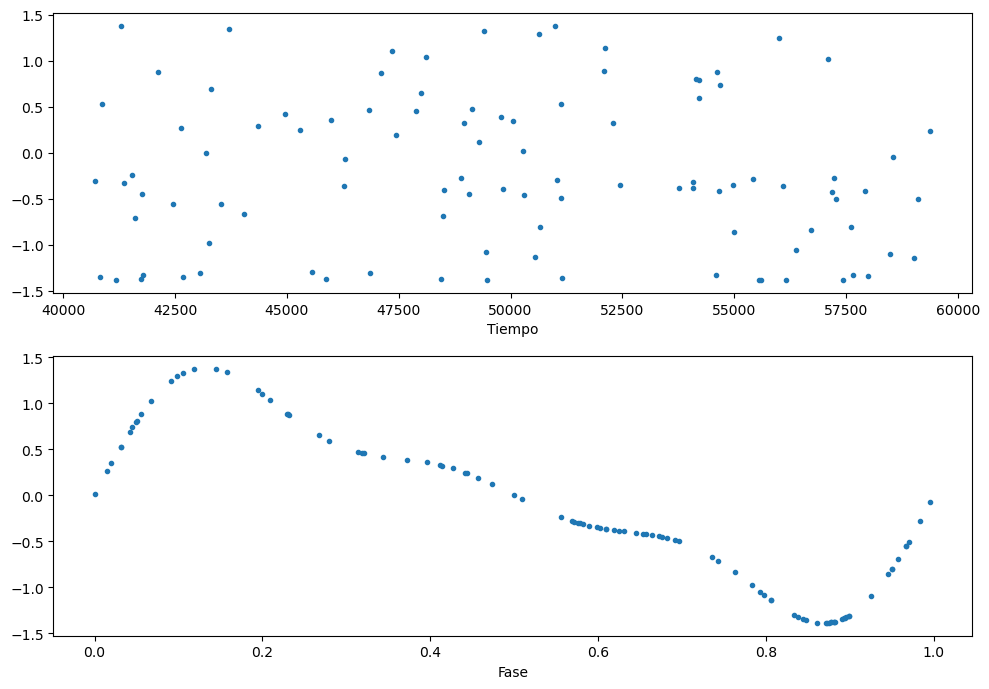

In [2]:
P = 1.24

mjd, mag = random_periodic_sin_mix(period=P, s_noise=0, irregular=False)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Positional Encoding (original)

In [38]:
data = lc_dataset()
data.add_curves('sinmix', N=800, seq_len=200, min_period=0.5, max_period=2, label=0)

batch_size = 64

data_loader = DataLoader(
    data,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=16,
    shuffle=True)

In [39]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        print(x.shape)
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [40]:
for i in data_loader:
    temp = i
    break

In [41]:
pe = PositionalEncoding(200, 0)

In [56]:
pe(i['mag'].reshape(64,200,1))

torch.Size([64, 200, 1])


tensor([[[ 1.2018,  2.2018,  1.2018,  ...,  2.2018,  1.2018,  2.2018],
         [ 0.8579,  0.5567,  0.8071,  ...,  1.0164,  0.0165,  1.0164],
         [ 1.2816, -0.0438,  1.3404,  ...,  1.3723,  0.3725,  1.3723],
         ...,
         [ 2.5635,  1.1621,  1.2069,  ...,  2.7674,  1.7893,  2.7674],
         [ 0.1283, -0.7889, -0.7901,  ...,  1.2076,  0.2296,  1.2077],
         [-1.0524, -0.6422, -0.8316,  ...,  0.8291, -0.1488,  0.8292]],

        [[-0.8279,  0.1721, -0.8279,  ...,  0.1721, -0.8279,  0.1721],
         [ 1.3380,  1.0369,  1.2873,  ...,  1.4966,  0.4967,  1.4966],
         [ 0.8391, -0.4864,  0.8979,  ...,  0.9298, -0.0700,  0.9298],
         ...,
         [ 2.0822,  0.6809,  0.7256,  ...,  2.2862,  1.3080,  2.2862],
         [ 1.5721,  0.6549,  0.6537,  ...,  2.6514,  1.6734,  2.6514],
         [-0.5567, -0.1465, -0.3359,  ...,  1.3248,  0.3469,  1.3249]],

        [[-0.8096,  0.1904, -0.8096,  ...,  0.1904, -0.8096,  0.1904],
         [ 1.4036,  1.1024,  1.3529,  ...,  1

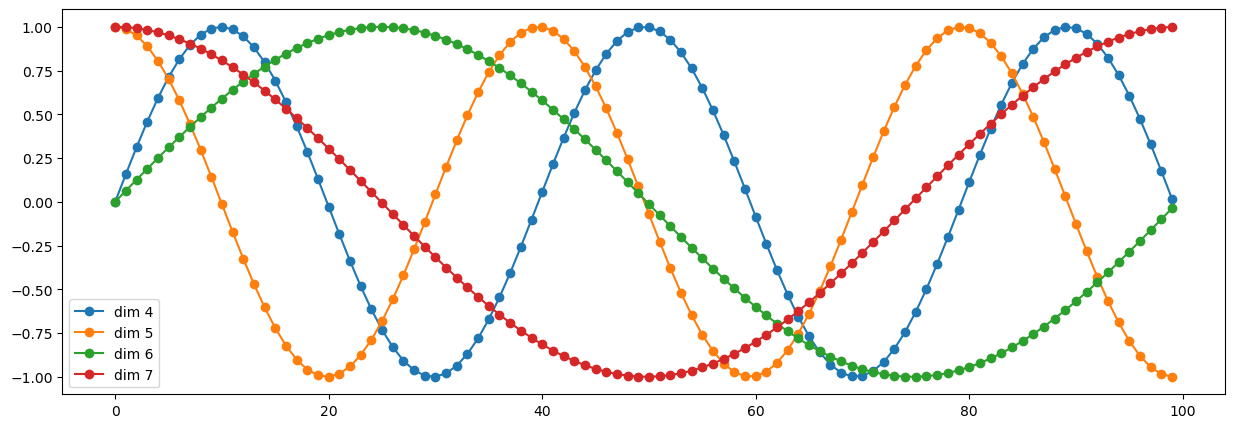

In [12]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy(), marker='o')
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Positional Encoding (Sousa)

In [33]:
class PositionalEncodingSousa(nn.Module):
    "Implement the PE function."
    def __init__(self, d_TE, maxtime, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = torch.zeros(max_len, d_TE)
        self.div_term = torch.exp(torch.arange(0, d_TE, 2) *
                             -(math.log(maxtime) / d_TE))
        
    def forward(self, x, time):
        position = torch.arange(0, time).unsqueeze(1)
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        self.pe[:, 0::2] = torch.sin(position * self.div_term)
        self.pe[:, 1::2] = torch.cos(position * self.div_term)
        self.pe = self.pe.unsqueeze(0)
        self.register_buffer('pe', self.pe)
        
        return self.dropout(x)